In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

# Function to calculate RSI
def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    data['RSI'] = rsi
    return data



C:\Users\Nayamat\AppData\Local\Temp\ipykernel_21120\4022196465.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date)
[*********************100%***********************]  1 of 1 completed


Data fetched from 2015-07-10 to 2025-07-10
Price            Close        RSI
Ticker            MSFT           
Date                             
2025-07-03  498.839996  69.452545
2025-07-07  497.720001  73.444573
2025-07-08  496.619995  69.225662
2025-07-09  503.510010  74.848767
2025-07-10  498.690002  67.124553


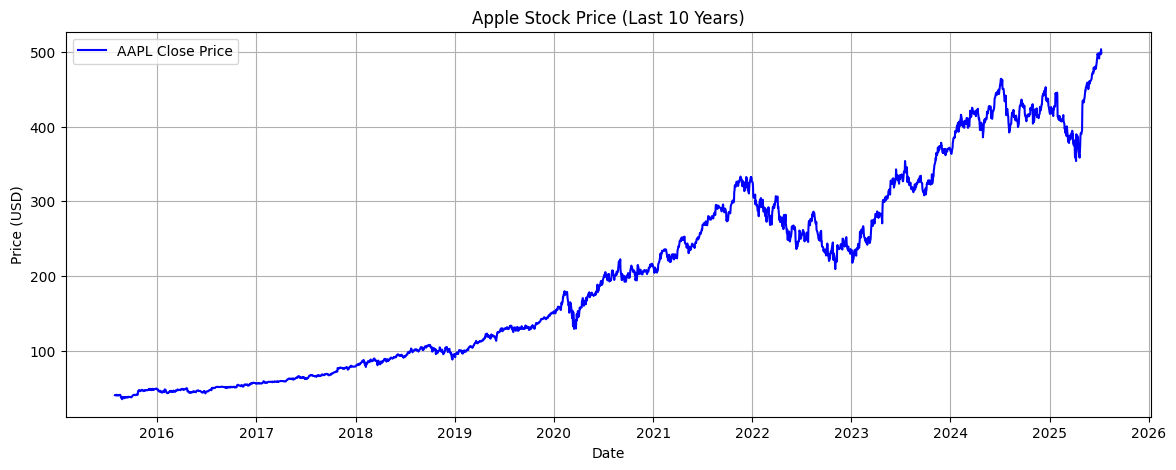

In [23]:
# Define the ticker and start date (10 years back)
from datetime import datetime
ticker = "MSFT"
start_date = (datetime.now() - pd.DateOffset(years=10)).strftime('%Y-%m-%d')

# Fetch data
data = yf.download(ticker, start=start_date)
data = data[['Close']]  # Keep only the 'Close' column

# Compute RSI
data = compute_RSI(data, window=14)

# Drop rows with NaNs (due to RSI rolling window)
data.dropna(inplace=True)

# Show range and recent data
print(f"Data fetched from {start_date} to {data.index[-1].strftime('%Y-%m-%d')}")
print(data.tail())

# Plot closing price
plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label='AAPL Close Price', color='blue')
plt.title('Apple Stock Price (Last 10 Years)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()



In [24]:
print(data.isnull().sum())


Price  Ticker
Close  MSFT      0
RSI              0
dtype: int64


In [25]:
from sklearn.preprocessing import MinMaxScaler

# Scale both Close and RSI
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close', 'RSI']])

# Convert back to DataFrame
scaled_data = pd.DataFrame(scaled_data, index=data.index, columns=['Close', 'RSI'])

# Preview scaled data
print("Scaled data head:")
print(scaled_data.head())



Scaled data head:
               Close       RSI
Date                          
2015-07-30  0.011377  0.634782
2015-07-31  0.011044  0.562858
2015-08-03  0.011248  0.564873
2015-08-04  0.012600  0.601118
2015-08-05  0.012674  0.546052


In [26]:
import numpy as np

X = []
y = []
sequence_length = 60

for i in range(sequence_length, len(scaled_data)):
    # 60 days of both features (Close & RSI)
    X.append(scaled_data.iloc[i-sequence_length:i].values)
    
    # Predicting Close price only
    y.append(scaled_data.iloc[i, 0])

X = np.array(X)
y = np.array(y)

print("Shape of X:", X.shape)  # (samples, 60, 2)
print("Shape of y:", y.shape)



Shape of X: (2441, 60, 2)
Shape of y: (2441,)


In [27]:
# 80% training, 20% testing
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Shapes
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)



Training set shape: (1952, 60, 2) (1952,)
Testing set shape: (489, 60, 2) (489,)


In [28]:
#%pip install tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

model = Sequential()

# First LSTM Layer (update input shape to use 2 features)
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second LSTM Layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(units=1))  # Predicting one value (next day Close price)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Show summary
model.summary()


c:\Users\Nayamat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,851 (120.51 KB)

 Trainable params: 30,851 (120.51 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# %pip install protobuf==3.20.3



Epoch 1/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 0.0208 - val_loss: 0.0017
Epoch 2/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 3/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 4/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 5/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 9.6436e-04 - val_loss: 6.6104e-04
Epoch 6/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 9.3384e-04 - val_loss: 8.4864e-04
Epoch 7/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0010 - val_loss: 8.6861e-04
Epoch 8/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0010 - val_loss: 9.2818e-04
Epoch 9/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 8.4770e-04 - val_loss: 0.0024
Epoch 10/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 8.9889e-04 - val_loss: 0.0029
Epoch 11/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 7.9434e-04 - val_loss: 0.0020
Epoch 12/60
61/61 ━━━━━━━━━

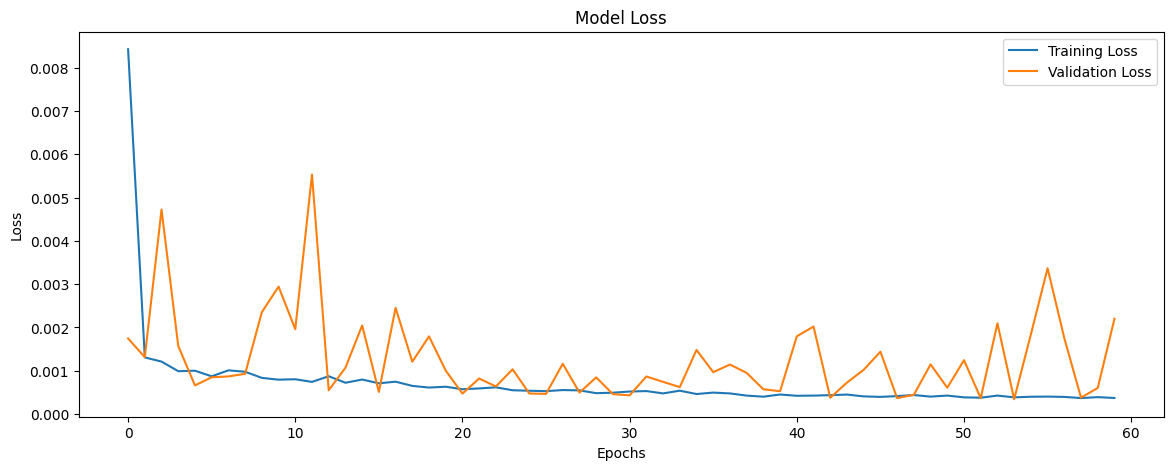

In [30]:
history = model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=32,
    validation_data=(X_test, y_test)
)
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


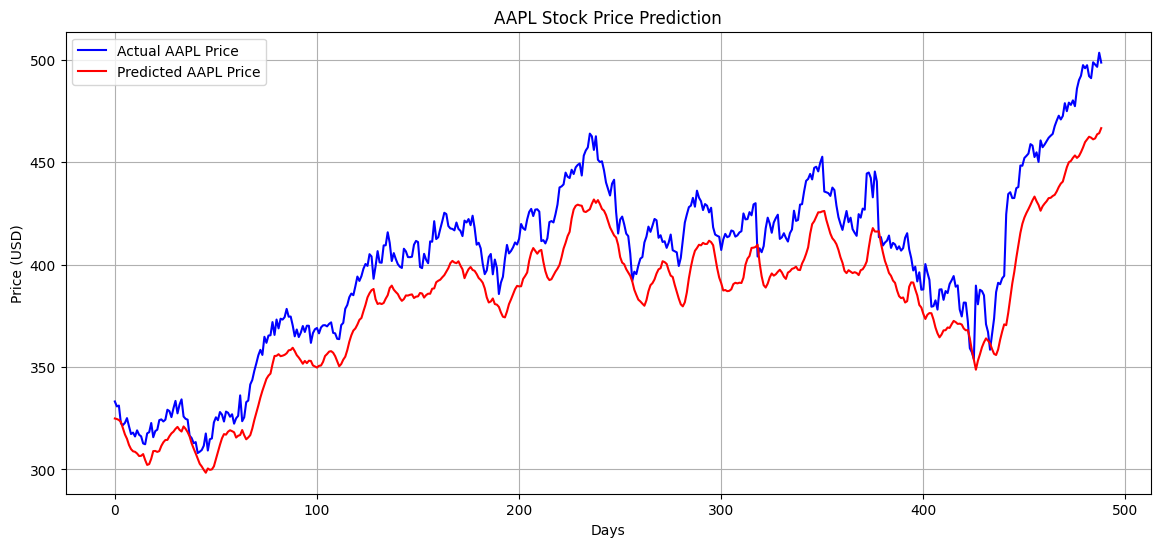

In [31]:
# Predict using the trained model
predicted_prices = model.predict(X_test)

# Create a dummy array with both Close and RSI (since scaler expects 2 columns)
# We'll put predictions in the 'Close' column and 0s in RSI
predicted_full = np.hstack((predicted_prices, np.zeros_like(predicted_prices)))
actual_full = np.hstack((y_test.reshape(-1, 1), np.zeros_like(y_test.reshape(-1, 1))))

# Invert scaling
predicted_prices_actual = scaler.inverse_transform(predicted_full)[:, 0]  # only take 'Close'
actual_prices_actual = scaler.inverse_transform(actual_full)[:, 0]

# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(actual_prices_actual, color='blue', label='Actual AAPL Price')
plt.plot(predicted_prices_actual, color='red', label='Predicted AAPL Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
📈 Predicted closing price for the next day: $466.42


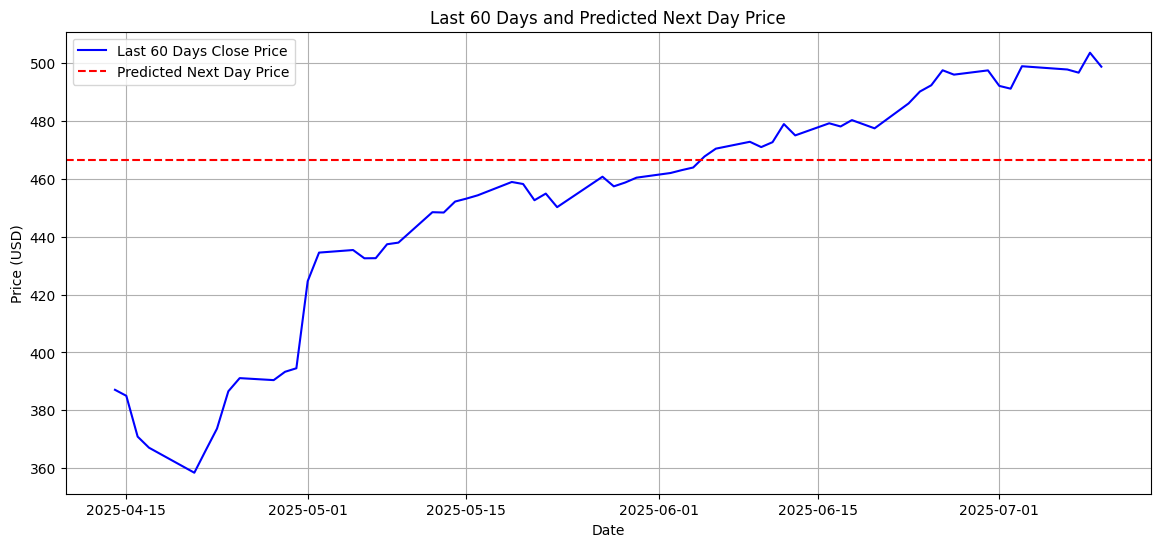

In [32]:
import numpy as np

# Step 1: Get the last 60 days from the original DataFrame (Close + RSI)
last_60_days = data[['Close', 'RSI']].values[-60:]  # shape = (60, 2)

# Step 2: Normalize using the same scaler used earlier
scaled_last_60 = scaler.transform(last_60_days)

# Step 3: Reshape to (1, 60, 2) for LSTM input
X_future = np.reshape(scaled_last_60, (1, 60, 2))

# Step 4: Predict the next day's price (scaled)
predicted_next_price = model.predict(X_future)

# Step 5: Inverse scale (with dummy RSI column)
predicted_full = np.hstack((predicted_next_price, np.zeros_like(predicted_next_price)))
predicted_next_price_actual = scaler.inverse_transform(predicted_full)[0][0]

# Step 6: Show predicted price
print(f"📈 Predicted closing price for the next day: ${predicted_next_price_actual:.2f}")

# Step 7: Visualize
plt.figure(figsize=(14, 6))
plt.plot(data.index[-60:], last_60_days[:, 0], label='Last 60 Days Close Price', color='blue')
plt.axhline(y=predicted_next_price_actual, color='red', linestyle='--', label='Predicted Next Day Price')
plt.title('Last 60 Days and Predicted Next Day Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Step 1: Predict on the test set
predictions = model.predict(X_test)

# Step 2: Prepare 2D inputs for inverse transform (Close + dummy RSI)
predicted_full = np.hstack((predictions, np.zeros_like(predictions)))
actual_full = np.hstack((y_test.reshape(-1, 1), np.zeros_like(y_test.reshape(-1, 1))))

# Step 3: Inverse transform
predicted_prices = scaler.inverse_transform(predicted_full)[:, 0]
actual_prices = scaler.inverse_transform(actual_full)[:, 0]

# Step 4: Calculate metrics
mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))

# Step 5: Print results
print(f"📉 Mean Absolute Error (MAE): ${mae:.2f}")
print(f"📊 Root Mean Squared Error (RMSE): ${rmse:.2f}")



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
📉 Mean Absolute Error (MAE): $19.98
📊 Root Mean Squared Error (RMSE): $21.96


In [14]:


# def compute_RSI(data, window=14):
#     delta = data['Close'].diff()

#     gain = delta.clip(lower=0)
#     loss = -delta.clip(upper=0)

#     avg_gain = gain.rolling(window=window, min_periods=window).mean()
#     avg_loss = loss.rolling(window=window, min_periods=window).mean()

#     rs = avg_gain / avg_loss
#     rsi = 100 - (100 / (1 + rs))

#     data['RSI'] = rsi
#     return data

# Use it
data = compute_RSI(data, window=14)

# Drop initial rows with NaN from RSI calculation
data.dropna(inplace=True)

# Preview
print(data[['Close', 'RSI']].tail())


Empty DataFrame
Columns: [(Close, AAPL), (RSI, )]
Index: []
